In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import tqdm

In [28]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

In [2]:
rawtrain = pd.read_csv('train.csv')
rawtest = pd.read_csv('test.csv')
age_gender = pd.read_csv('age_gender_info.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv')

###   
### 지역정보 join (운전가능연령: 20~70대)

In [3]:
female = []
male = []
for col in age_gender.columns:
    female.append(col) if '여자' in col else male.append(col)
        
female_ratio = pd.DataFrame(age_gender[female].iloc[:, 2:8].sum(axis=1), columns=['여자운전비율'])
male_ratio = pd.DataFrame(age_gender[male].iloc[:, 2:8].sum(axis=1), columns=['남자운전비율'])

rawtrain = pd.merge(rawtrain, female_ratio, on='지역')
rawtrain = pd.merge(rawtrain, male_ratio, on='지역')
rawtest = pd.merge(rawtest, female_ratio, on='지역')
rawtest = pd.merge(rawtest, male_ratio, on='지역')

In [4]:
rawtrain.groupby(['공급유형']).count()

,단지코드,총세대수,임대건물구분,지역,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,여자운전비율,남자운전비율
공급유형,,,,,,,,,,,,,,,,
공공분양,7,7,7,7,7,7,7,7,0,0,0,7,7,7,7,7
공공임대(10년),205,205,205,205,205,205,205,205,205,205,198,201,205,205,205,205
공공임대(50년),31,31,31,31,31,31,31,31,31,31,20,31,31,31,31,31
공공임대(5년),3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
공공임대(분납),12,12,12,12,12,12,12,12,12,12,9,12,12,12,12,12
국민임대,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758,1727,1758,1758,1758,1758,1758
영구임대,152,152,152,152,152,152,152,152,152,152,127,152,152,152,152,152
임대상가,562,562,562,562,562,562,562,562,0,0,435,562,562,562,562,562
장기전세,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


###  
### 오류 단지코드 제외
### 1. 전용면적별 세대수 합계와 총세대수 일치 x: 전용면적별 세대수 합계를 총 세대수로 설정하고 진행
### 2. 동일한 단지에 단지코드가 2개로 부여된 경우: train(2085, 1397, 2431, 1649, 1036), test(2675) 

In [5]:
def exception():
    # 1. 전용면적별 세대수 합계 join
    _t1 = rawtrain.groupby('단지코드').sum()['전용면적별세대수']
    _t2 = pd.merge(rawtrain, _t1, on='단지코드')
    _t2['전용면적별세대수'] = _t2['전용면적별세대수_x']
    _t2['총세대수'] = _t2['전용면적별세대수_y']
    _final1 = _t2.drop(['전용면적별세대수_x', '전용면적별세대수_y'], axis='columns')
    
    # 2. 제외할 코드들 제외
    train = _final1[~_final1['단지코드'].isin(['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 
                                             'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])]
    test = rawtest[~rawtest['단지코드'].isin(['C2675', 'C2335', 'C1327'])]
    
    return train, test

In [6]:
train, test = exception()

###  
### 결측치 처리

In [7]:
def nanprocess_v1(usetrain):

    """
        도보 10분거리내 지하철역 수: "지역별로" 결측치 제외 평균 0.5 미만이면 0, 이상이면 1 부여
        cf. 대전과 충청남도에만 결측치 있음    
        
    """
    cities = list(set(usetrain['지역']))
    aparts = list(set(usetrain['단지코드']))
    _pre1 = usetrain.copy()
    
    _col = '도보 10분거리 내 지하철역 수(환승노선 수 반영)'
    for city in tqdm(cities):
        _aparts_in_city = usetrain[usetrain['지역'] == city]
        _codes_in_city = list(set(_aparts_in_city['단지코드']))
        
        _mean = np.nanmean(_aparts_in_city[_col])
        for code in _codes_in_city:
            _idx = _pre1[_pre1['단지코드']==code].index
            if usetrain[usetrain['단지코드'].isin(_codes_in_city)][_col].isnull().sum() > 0:
                if _mean >= 0.5:
                    _pre1.loc[_idx, _col] = 1
                else:
                    _pre1.loc[_idx, _col] = 0
                    
    """
        임대보증금 및 임대료: 결측치 제외하고, 단지별로, 전용면적과 선형회귀분석 진행하여 결측치 처리
        cf. 임대보증금, 임대료에 '-' 값 있음: 결측치로 처리 
        cf. C2152 아파트의 경우 임대보증금/임대료 데이터가 아예 결측 -> 강원도평균으로 처리
        
    """        
    # 임대가치 지표 신규 설정
    _pre2 = _pre1.copy()
    _col = ['임대보증금', '임대료']

    for col in _col:
        _pre2 = _pre2.drop(_pre2[_pre2[col] == '-'].index)
        _pre2[col] = _pre2[col].astype(float)
    _pre2['임대가치'] = _pre2['임대보증금'] * _pre2['임대료']
    
    
#     # 이상치 제거, 선형회귀식 작성에 사용할 데이터 추출
#     q1 = _pre1['임대가치'].quantile(0.25)
#     q3 = _pre1['임대가치'].quantile(0.75)
#     IQR = q3 - q1
#     _lin = _pre1[(_pre1['임대가치'] < (q1 - 1.5 * IQR)) | (_pre1['임대가치'] > (q3 + 1.5 * IQR))]
    
#     # 선형회귀식 작성
#     cities = list(set(_pre1['지역']))
#     aparts = list(set(_pre1['단지코드']))
    
#     for apart in tqdm(aparts):
#         _dat1 = _lin[_lin['단지코드'] == apart]
#         linmodel = stats.linregress(list(_lin['전용면적'].astype(float)), list(_lin['임대가치'].astype(float)))
#         _idx1 = _pre1[_pre1['단지코드'] == apart].isnull().index
#         for idx in _idx1:
#             _pre1.loc[idx, '임대가치'] = linmodel.intercept + linmodel.slope * _pre1.loc[idx, '전용면적']
    
#     final = _pre1[(_pre1['임대가치'] >= (q1 - 1.5 * IQR)) & (_pre1['임대가치'] <= (q3 + 1.5 * IQR))]
    
    return _pre1, _pre2
    
    

In [8]:
_, prep_train = nanprocess_v1(train)
_forC2152, prep_test = nanprocess_v1(test)

# 강원도 임대가치 평균으로 C2152 결측치 처리
_forC2152['임대가치'] = np.mean(prep_test[prep_test['지역']=='강원도']['임대가치'])
prep_test = pd.concat([prep_test, _forC2152[_forC2152['단지코드'] == 'C2152']])
prep = pd.concat([prep_train, prep_test])

100%|██████████| 15/15 [00:00<00:00, 98.43it/s] 


In [30]:
prep

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,여자운전비율,남자운전비율,전용면적별세대수,임대가치
8,C2371,474,아파트,경상북도,국민임대,36.52,20.0,A,9.731e+06,72080,0.0,1.0,374.0,451.0,0.414740,0.356251,42,7.014105e+11
9,C2371,474,아파트,경상북도,국민임대,36.52,20.0,A,9.731e+06,72080,0.0,1.0,374.0,451.0,0.414740,0.356251,134,7.014105e+11
10,C2371,474,아파트,경상북도,국민임대,36.80,20.0,A,9.731e+06,72080,0.0,1.0,374.0,451.0,0.414740,0.356251,88,7.014105e+11
11,C2371,474,아파트,경상북도,국민임대,46.90,20.0,A,1.7302e+07,108130,0.0,1.0,374.0,451.0,0.414740,0.356251,22,1.870865e+12
12,C2371,474,아파트,경상북도,국민임대,46.90,20.0,A,1.7302e+07,108130,0.0,1.0,374.0,451.0,0.414740,0.356251,96,1.870865e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,C1229,453,아파트,세종특별자치시,행복주택,38.25,23.0,J,3.0101e+07,120400,0.0,2.0,317.0,NaN,0.418959,0.378229,3,3.624160e+12
1020,C1229,453,아파트,세종특별자치시,행복주택,38.28,23.0,J,3.0101e+07,120400,0.0,2.0,317.0,NaN,0.418959,0.378229,4,3.624160e+12
1021,C1229,453,아파트,세종특별자치시,행복주택,44.02,23.0,J,3.3983e+07,135930,0.0,2.0,317.0,NaN,0.418959,0.378229,30,4.619309e+12
700,C2152,120,아파트,강원도,영구임대,24.83,9.0,C,-,-,0.0,1.0,40.0,NaN,0.419817,0.360433,66,3.199641e+12


###  
### string 데이터 처리 / 상가 데이터 처리   (one-hot encoding)

In [15]:
# 지역
local_map = {}
for i, loc in enumerate(prep['지역'].unique()):
    _arr = [0] * len(prep['지역'].unique())
    _arr[i] = 1
    local_map[loc] = _arr
    
# 공급유형
supply_map = {}
for i, loc in enumerate(prep['공급유형'].unique()):
    _arr = [0] * len(prep['공급유형'].unique())
    _arr[i] = 1
    supply_map[loc] = _arr
    
# 자격유형
qual_map = {}
for i, loc in enumerate(prep['자격유형'].unique()):
    _arr = [0] * len(prep['자격유형'].unique())
    _arr[i] = 1
    qual_map[loc] = _arr

In [32]:
def preprocess_v1(prep, type='train'):
    aparts = list(set(prep['단지코드']))
    merge_set = []
    for code in tqdm(aparts):
        final_vector = {}

        usedat = prep[prep['단지코드'] == code]
        onlyapart = usedat[usedat['임대건물구분'] == '아파트']
        
        if '상가' in set(usedat['임대건물구분']):
            sanga = 1
            sangadat = usedat[usedat['임대건물구분'] == '상가']
            apartdat = usedat[usedat['임대건물구분'] == '아파트']
            sanga_area = sum(sangadat['전용면적'] * sangadat['전용면적별세대수'])
            apart_area = sum(apartdat['전용면적'] * apartdat['전용면적별세대수'])
        else:
            sanga = 0
            sanga_area = 0.0
            apart_area = sum(usedat['전용면적'] * usedat['전용면적별세대수'])
        
        final_vector['단지코드'] = [usedat['단지코드'].iloc[0]]
        final_vector['총세대수'] = [usedat['총세대수'].iloc[0]]
        final_vector['상가'] = [sanga]
        final_vector['아파트면적'] = [apart_area]
        final_vector['상가면적'] = [sanga_area]
        
        _onehot = sum([np.array(local_map[key]) for key in usedat['지역'].unique()])    # 지역정보
        for tp in zip(list(local_map.keys()), list(_onehot)):
            final_vector[tp[0]] = tp[1]
            
        _onehot = sum([np.array(supply_map[key]) * usedat.iloc[idx]['전용면적별세대수'] for idx, key in enumerate(usedat['공급유형'])])    # 공급유형
        for tp in zip(supply_map.keys(), _onehot):
            final_vector[tp[0]] = tp[1]
            
        _onehot = sum([np.array(qual_map[key]) * usedat.iloc[idx]['전용면적별세대수'] for idx, key in enumerate(usedat['자격유형'])])    # 자격유형
        for tp in zip(qual_map.keys(), _onehot):
            final_vector[tp[0]] = tp[1]     

        final_vector['공가수'] = [usedat['공가수'].iloc[0]]            
        final_vector['임대가치'] = [usedat['임대가치'].iloc[0]]
        final_vector['지하철'] = [usedat['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].iloc[0]]
        final_vector['버스'] = [usedat['도보 10분거리 내 버스정류장 수'].iloc[0]]
        final_vector['주차면수'] = [usedat['단지내주차면수'].iloc[0]]
        if type == 'train':
            final_vector['등록차량수'] = [usedat['등록차량수'].iloc[0]]
        
        merge_set.append(pd.DataFrame(final_vector))
    
    return pd.concat(merge_set)

finaltrain = preprocess_v1(prep_train).dropna()
finaltest = preprocess_v1(prep_test, 'test')

100%|██████████| 147/147 [00:00<00:00, 152.74it/s]


In [33]:
finaltrain

,단지코드,총세대수,상가,아파트면적,상가면적,경상북도,경상남도,대전광역시,경기도,전라북도,강원도,광주광역시,충청남도,부산광역시,제주특별자치도,울산광역시,충청북도,전라남도,대구광역시,서울특별시,세종특별자치시,국민임대,공공임대(10년),행복주택,영구임대,임대상가,공공임대(50년),공공분양,공공임대(분납),공공임대(5년),A,E,H,J,C,D,I,L,K,B,G,N,M,O,F,NaN,공가수,임대가치,지하철,버스,주차면수,등록차량수
0,C1360,443,0,18209.93,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,443,0,0,0,0,0,0,0,0,443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.0,6.767251e+11,0.0,2.0,362.0,375.0
0,C2137,960,0,38020.20,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,960,0,0,0,0,0,0,0,0,540,420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.0,1.134472e+12,0.0,8.0,876.0,752.0
0,C2359,820,0,25122.32,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,536,0,0,284,0,0,0,0,0,0,0,536,0,0,0,284,0,0,0,0,0,0,0,0,0,9.0,6.229980e+11,0.0,3.0,629.0,693.0
0,C1722,809,1,32619.48,232.66,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,298,6,505,0,0,0,505,0,0,0,298,6,0,0,0,0,0,0,0,0,0,0,1.0,1.900537e+12,0.0,6.0,264.0,649.0
0,C1049,676,0,28955.31,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,676,0,0,0,0,0,0,0,0,676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.0,1.407518e+12,0.0,3.0,658.0,762.0
0,C2308,285,0,16087.86,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,285,0,0,0,0,0,0,0,0,285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,2.238848e+12,0.0,1.0,200.0,244.0
0,C1468,815,0,35451.43,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,815,0,0,0,0,0,0,0,0,815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,1.617118e+12,0.0,1.0,574.0,810.0
0,C2262,720,0,33358.55,0.00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,720,0,0,0,0,0,0,0,0,720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.0,2.362848e+12,0.0,4.0,581.0,540.0
0,C1227,806,0,32720.04,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,806,0,0,0,0,0,0,0,0,806,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0,1.818831e+12,0.0,1.0,707.0,823.0
0,C1394,466,0,19188.97,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,466,0,0,0,0,0,0,0,0,466,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8.324660e+11,0.0,1.0,329.0,271.0


In [37]:
finaltrain = finaltrain[finaltrain['임대가치']<5e12]

In [35]:
finaltrain[finaltrain['임대가치']<5e12]

,단지코드,총세대수,상가,아파트면적,상가면적,지역,공급유형,공가수,자격유형,임대가치,지하철,버스,주차면수,등록차량수
0,C1386,1497,0,63973.48,0.00,12,0,15.0,0,8.301401e+11,0.0,5.0,1100.0,1145.0
0,C2490,302,0,16494.40,0.00,13,0,4.0,0,4.625282e+12,0.0,2.0,217.0,340.0
0,C1032,946,0,51895.52,0.00,2,0,6.0,0,1.998310e+12,1.0,2.0,986.0,316.0
0,C2212,697,1,20010.42,583.25,5,3,0.0,4,3.018355e+11,0.0,4.0,128.0,86.0
0,C2262,720,0,33358.55,0.00,10,0,30.0,0,2.362848e+12,0.0,4.0,581.0,540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,C1693,853,0,47155.53,0.00,2,0,20.0,0,3.895913e+12,1.0,6.0,862.0,1087.0
0,C2208,882,0,38890.20,0.00,3,0,16.0,0,2.433786e+12,0.0,2.0,755.0,840.0
0,C1312,517,0,21996.87,0.00,7,0,12.0,0,2.133787e+12,0.0,3.0,527.0,359.0
0,C1360,443,0,18209.93,0.00,0,0,22.0,0,6.767251e+11,0.0,2.0,362.0,375.0


In [24]:
# for i in finaltrain.columns.difference(['단지코드']):
#     print(i)
#     plt.hist(finaltrain[i])
#     plt.show()

###  
### Normalization

In [38]:
means = {}
stds = {}
for col in finaltrain.columns.difference(['단지코드']):
    means[col] = np.mean(finaltrain[col])
    stds[col] = np.std(finaltrain[col])
    finaltrain[col] = (finaltrain[col] - means[col]) / stds[col]
    
for col in finaltest.columns.difference(['단지코드']):
    finaltest[col] = (finaltest[col] - means[col]) / stds[col]

공가수


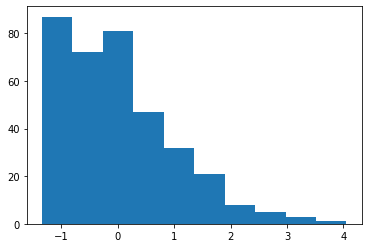

공급유형


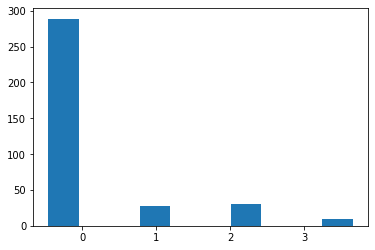

등록차량수


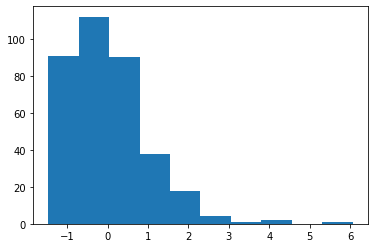

버스


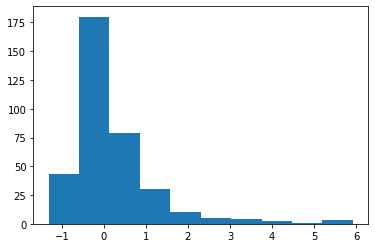

상가


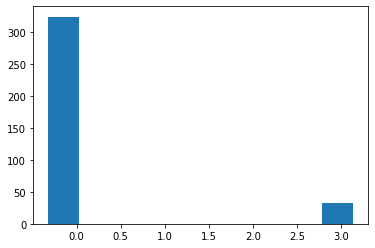

상가면적


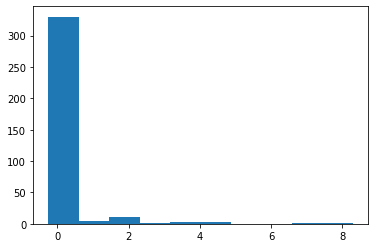

아파트면적


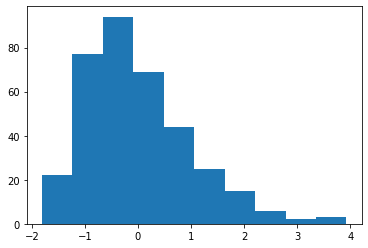

임대가치


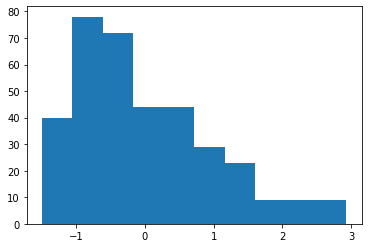

자격유형


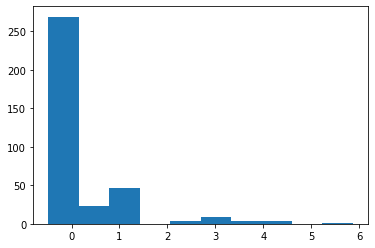

주차면수


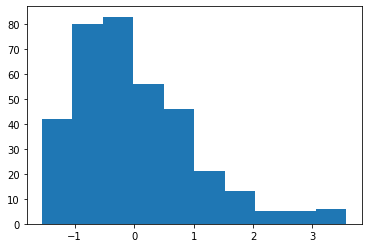

지역


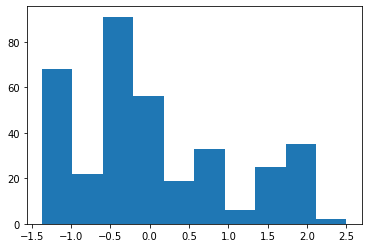

지하철


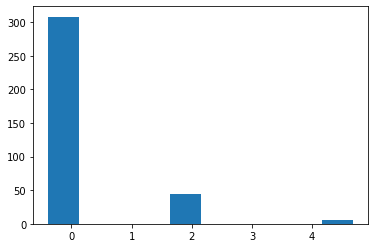

총세대수


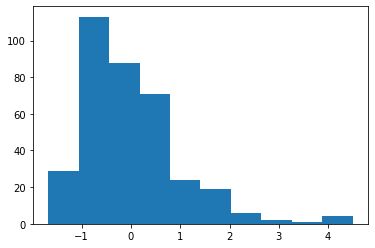

In [39]:
for i in finaltrain.columns.difference(['단지코드']):
    print(i)
    plt.hist(finaltrain[i])
    plt.show()

###  
### 학습 시작

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE

import time

In [73]:
train_validation = {}
except_val = []

tmp_finaltrain = np.array(finaltrain[finaltrain.columns.difference(except_val)])
np.random.seed(777)
np.random.shuffle(np.array(tmp_finaltrain))
thres = int(tmp_finaltrain.shape[0] / 5)

x_train = pd.DataFrame(tmp_finaltrain[:-thres], columns=finaltrain.columns.difference(except_val))
x_validation = pd.DataFrame(tmp_finaltrain[-thres:], columns=finaltrain.columns.difference(except_val))

X = x_train[x_train.columns.difference(['등록차량수', '단지코드'])].astype(float)
y = x_train[['등록차량수']].astype(float)

def myLR():
    model = LinearRegression()
    fit = model.fit(X, y)
    print(f'Linear Regression Score: {MAE(y, fit.predict(X))}')

In [74]:
def myRegressor(regressor, param_grid):
    start = time.time()
    reg_grid = GridSearchCV(estimator=regressor,
                            param_grid=param_grid,
                            scoring='neg_mean_absolute_error',
                            n_jobs=60,
                            cv=5,
                            refit=True,
                            return_train_score=True)
    reg_grid.fit(X, y)
    result = pd.DataFrame(reg_grid.cv_results_)[
        ['params', 'mean_test_score', 'rank_test_score']
    ].sort_values(by='rank_test_score')
    print(f'소요시간: {round((time.time() - start) / 60, 2)}분')
    
    return result

In [75]:
def finalxgb(n_jobs, params):
    start = time.time()
    x_train, y_train = X.copy(), y.copy()
    xgb_clf = xgb.XGBRegressor()
    xgb_param_grid  = {
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': [5],
        'min_child_weight': [1],
        'gamma': [0],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'nthread': [-1],
        'scale_pos_weight': [1],
        'tree_method': ['gpu_hist'],
        'gpu_id': params['gpu_id'],
        'seed': [123]
    }

    def GridXGB(xgb_clf, xgb_param_grid):
        hr_grid = GridSearchCV(estimator=xgb_clf,
                           param_grid=xgb_param_grid,
                           scoring='neg_mean_absolute_error',
                           n_jobs=n_jobs,
                           cv=5,
                           refit=True,
                           return_train_score=True)
        hr_grid.fit(x_train, y_train)
        return hr_grid

    hr_grid = GridXGB(xgb_clf, xgb_param_grid)
    hr_grid_df = pd.DataFrame(hr_grid.cv_results_).sort_values(by='rank_test_score')
    print(f'Best MAE: {hr_grid_df.iloc[0]["mean_test_score"]}')

    s1 = xgb_clf
    s1.set_params(**hr_grid.best_params_)
    print(f'Learning Rate, n_estimators FINISHED !! Time Spent: {round((time.time() - start) / 60, 2)} mins')
    print(hr_grid.best_params_)

    xgb_param_grid  = {
        'max_depth': params['max_depth'],
        'min_child_weight': [1, 2, 3, 4, 5]
    }

    hr_grid = GridXGB(s1, xgb_param_grid)
    hr_grid_df = pd.DataFrame(hr_grid.cv_results_).sort_values(by='rank_test_score')
    print(f'Best MAE: {hr_grid_df.iloc[0]["mean_test_score"]}')

    s1 = xgb_clf
    s1.set_params(**hr_grid.best_params_)
    print(f'max_depth, min_child_weight FINISHED !! Time Spent: {round((time.time() - start) / 60, 2)} mins')
    print(hr_grid.best_params_)

    xgb_param_grid  = {
        'gamma': params['gamma']
    }

    hr_grid = GridXGB(s1, xgb_param_grid)
    hr_grid_df = pd.DataFrame(hr_grid.cv_results_).sort_values(by='rank_test_score')
    print(f'Best MAE: {hr_grid_df.iloc[0]["mean_test_score"]}')

    s1 = xgb_clf
    s1.set_params(**hr_grid.best_params_)
    print(f'gamma FINISHED !! Time Spent: {round((time.time() - start) / 60, 2)} mins')
    print(hr_grid.best_params_)


    xgb_param_grid  = {
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree']
    }

    hr_grid = GridXGB(s1, xgb_param_grid)
    hr_grid_df = pd.DataFrame(hr_grid.cv_results_).sort_values(by='rank_test_score')
    print(f'Best MAE: {hr_grid_df.iloc[0]["mean_test_score"]}')

    s1 = xgb_clf
    s1.set_params(**hr_grid.best_params_)
    print(f'subsample, colsample_bytree FINISHED !! Time Spent: {round((time.time() - start) / 60, 2)} mins')
    print(hr_grid.best_params_)


    xgb_param_grid  = {
        'subsample': [i/100.0 for i in range(40,80)],
    }

    hr_grid = GridXGB(s1, xgb_param_grid)
    hr_grid_df = pd.DataFrame(hr_grid.cv_results_).sort_values(by='rank_test_score')
    print(f'Best MAE: {hr_grid_df.iloc[0]["mean_test_score"]}')

    s1 = xgb_clf
    s1.set_params(**hr_grid.best_params_)
    print(f'subsample FINISHED !! Time Spent: {round((time.time() - start) / 60, 2)} mins')
    print(hr_grid.best_params_)

    xgb_param_grid = {
     'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
    }

    hr_grid = GridXGB(s1, xgb_param_grid)
    hr_grid_df = pd.DataFrame(hr_grid.cv_results_).sort_values(by='rank_test_score')
    print(f'Best MAE: {hr_grid_df.iloc[0]["mean_test_score"]}')

    s1 = xgb_clf
    s1.set_params(**hr_grid.best_params_)
    print(f'Regularization FINISHED !! Time Spent: {round((time.time() - start) / 60, 2)} mins')
    print(hr_grid.best_params_)

    return hr_grid



In [76]:
rf_params = {
    'n_estimators': [10, 20, 30, 40, 50],
    'criterion': ['mae'],
    'max_depth': [20, 30, 40]
}

svr_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 2, 3],
    'epsilon': [0.01, 0.1, 0.5],
}

xgb_params = {
    'max_depth': list(range(3, 11)),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 3, 6, 9],
    'tree_method':['gpu_hist'],
    'gpu_id': [0],
    'learning_rate': [0.2, 0.05, 0.005],
    'n_estimators': [100, 200, 500]
}

In [77]:
result_rf = myRegressor(RandomForestRegressor(), rf_params)
result_svr = myRegressor(SVR(), svr_params)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


소요시간: 0.07분
소요시간: 0.0분


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [78]:
result_xgb = finalxgb(30, xgb_params)

Best MAE: -0.3617492596471233
Learning Rate, n_estimators FINISHED !! Time Spent: 0.61 mins
{'colsample_bytree': 0.8, 'gamma': 0, 'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'nthread': -1, 'scale_pos_weight': 1, 'seed': 123, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best MAE: -0.3570136128079409
max_depth, min_child_weight FINISHED !! Time Spent: 1.95 mins
{'max_depth': 3, 'min_child_weight': 2}
Best MAE: -0.3570136128079409
gamma FINISHED !! Time Spent: 2.02 mins
{'gamma': 0}
Best MAE: -0.3570136128079409
subsample, colsample_bytree FINISHED !! Time Spent: 2.54 mins
{'colsample_bytree': 0.8, 'subsample': 0.8}
Best MAE: -0.3582308497860828
subsample FINISHED !! Time Spent: 3.11 mins
{'subsample': 0.47}
Best MAE: -0.3593156917355399
Regularization FINISHED !! Time Spent: 3.2 mins
{'reg_alpha': 0.1}


In [79]:
rf_model = RandomForestRegressor(**result_rf['params'].iloc[0])
rf_model = rf_model.fit(X, y)

svr_model = SVR(**result_svr['params'].iloc[0])
svr_model = svr_model.fit(X, y)

xgb_model = xgb.XGBRegressor(**result_xgb.best_params_)
xgb_model = xgb_model.fit(X, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [80]:
X_val = x_validation[x_validation.columns.difference(['등록차량수', '단지코드'])].astype(float)
y_val = x_validation[['등록차량수']].astype(float)

score = MAE(y_val * stds['등록차량수'] + means['등록차량수'], rf_model.predict(X_val) * stds['등록차량수'] + means['등록차량수'])
print(score)
score = MAE(y_val * stds['등록차량수'] + means['등록차량수'], svr_model.predict(X_val) * stds['등록차량수'] + means['등록차량수'])
print(score)
score = MAE(y_val * stds['등록차량수'] + means['등록차량수'], xgb_model.predict(X_val) * stds['등록차량수'] + means['등록차량수'])
print(score)

104.2018309859155
101.87626831338129
103.2836396123322


In [89]:
def submission_return(test_model):
    finaltest['score'] = test_model.predict(finaltest[X.columns]) * stds['등록차량수'] + means['등록차량수']

    final = pd.DataFrame(np.array(finaltest[['단지코드', 'score']]), columns=['code', 'num'])

    final1 = pd.merge(sample_submission, final, how='outer', on='code')
    final1 = pd.DataFrame(np.array(final1[['code', 'num_y']]), columns=['code', 'num'])

    return final1

In [90]:
svr_submission = submission_return(svr_model)

In [81]:
final1.to_csv('submission1.csv', index=False)

In [93]:
svr_submission.to_csv('submission_svr1.csv', index=False)